In [1]:
import pylab as pl
import pandas as pd
import numpy as np
import os
import json
import scipy.stats

%pylab inline


Populating the interactive namespace from numpy and matplotlib


# Null Hypothesis



H_0: The trip duration for Citibike rides is equal for all riders during the day and at night.

_$H_0$ :  $Duration{\mathrm{daytime}} - Duration{\mathrm{nighttime}} = 0 $ 

H_1: The trip duration for Citibike rides during the day is not equal to the trip duration at night.

_$H_1$ :  $Duration{\mathrm{daytime}} - Duration{\mathrm{nighttime}} \neq 0 $ 

$ \sigma = 0.05 $


# Read in Data


In [2]:
# Download data and move to PUIDATA...
#  The following function will create the necessary commands
#   to download the data from CitiBike's website and load them
#   into multiple csv's.

def CitiBikedata(date):
    #create url to download data
    url = "https://s3.amazonaws.com/tripdata/" + date + "-citibike-tripdata.csv.zip"
    os.system("curl -O " + url)
    os.system("unzip " + date + "-citibike-tripdata.csv.zip")
    os.system("mv " + date + "-citibike-tripdata.csv $PUIDATA")
    os.system("rm " + date + "-citibike-tripdata.csv.zip")


In [3]:
#Download a 5 month range of data from April 2017 to August 2017. This for loop will load each csv into a dataframe
#  and add it to a list called frames. In the next cell, all these dataframes are concatenated into one dataframe to 
#  be used for the analysis. 

date_call_int = 201703
frames = []
for i in range(5):
    date_call_int = date_call_int + 1
    date_call = str(date_call_int)
    print("Loading data from " + date_call)
    CitiBikedata(date_call)
    df = pd.read_csv(os.getenv("PUIDATA") + "/" + date_call + '-citibike-tripdata.csv')
    frames.append(df)


Loading data from 201704
Loading data from 201705
Loading data from 201706
Loading data from 201707
Loading data from 201708


In [4]:
cb_data = pd.concat(frames)
cb_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,195,2017-04-01 00:00:58,2017-04-01 00:04:14,217,Old Fulton St,40.702772,-73.993836,430,York St & Jay St,40.701485,-73.986569,25454,Subscriber,1966.0,1
1,585,2017-04-01 00:01:54,2017-04-01 00:11:40,490,8 Ave & W 33 St,40.751551,-73.993934,3158,W 63 St & Broadway,40.771639,-73.982614,25930,Subscriber,1995.0,1
2,665,2017-04-01 00:01:56,2017-04-01 00:13:01,504,1 Ave & E 16 St,40.732219,-73.981656,412,Forsyth St & Canal St,40.715816,-73.994224,27110,Subscriber,1987.0,1
3,262,2017-04-01 00:02:24,2017-04-01 00:06:47,445,E 10 St & Avenue A,40.727408,-73.981420,411,E 6 St & Avenue D,40.722281,-73.976687,28392,Subscriber,1961.0,1
4,134,2017-04-01 00:02:36,2017-04-01 00:04:50,3423,West Drive & Prospect Park West,40.661063,-73.979453,3300,Prospect Park West & 8 St,40.665147,-73.976376,19316,Subscriber,1967.0,2


In [5]:
cb_data.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

# Data Wrangling (For Day/Night Analysis)

The next few cells will be working to ensure the data is in proper formats to be analyzed.

Since we will be looking at the difference in trip duration during the night and day, we need to define what constitutes night and day. For our purposes, I will define nighttime as any hour between 8pm and 5am. [8pm - 5am)

In [19]:
# Keep trip duration
# convert starttime to datetime
# create new 'hours' column and then drop all other columns. 


cb_data_DN = cb_data[['tripduration', 'starttime']]
cb_data_DN['tripduration'].dropna(inplace=True)
cb_data_DN['date'] = pd.to_datetime(cb_data_DN['starttime'])
cb_data_DN['hour'] = cb_data_DN['date'].dt.hour
cb_data_DN = cb_data_DN.drop(['starttime', 'date'], axis = 1)
cb_data_DN.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,tripduration,hour
0,195,0
1,585,0
2,665,0
3,262,0
4,134,0


In [20]:
#Count the number of rides per hour
num_hourly_rides = cb_data_DN['hour'].value_counts()
num_hourly_rides = num_hourly_rides.sort_index()

#Sum trip duration by hour. 
trip_dur_grouped = cb_data_DN.groupby('hour').sum()
trip_dur_grouped['hour'] = trip_dur_grouped.index
trip_dur_grouped = trip_dur_grouped.sort(['hour'], ascending=True)


#Divide summed trip duration by num_hourly_rides
trip_dur_grouped['num_rides'] = num_hourly_rides
trip_dur_grouped['avg_duration'] = trip_dur_grouped['tripduration'] / trip_dur_grouped['num_rides']
print(trip_dur_grouped)

      tripduration  hour  num_rides  avg_duration
hour                                             
0         88445975     0      72539   1219.288590
1         43843503     1      39598   1107.215087
2         24508183     2      22522   1088.188571
3         20721777     3      13563   1527.816633
4         17348624     4      13174   1316.883559
5         31891596     5      47434    672.336215
6        120390464     6     170791    704.899345
7        282260672     7     344260    819.905513
8        505785626     8     600432    842.369537
9        420854452     9     487187    863.845817
10       360447337    10     355098   1015.064396
11       422026009    11     382126   1104.415845
12       497633101    12     436041   1141.253004
13       522332101    13     455392   1146.994460
14       564280046    14     468338   1204.856420
15       603413215    15     494712   1219.726255
16       682892989    16     576912   1183.703908
17       879835971    17     808111   1088.756335


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


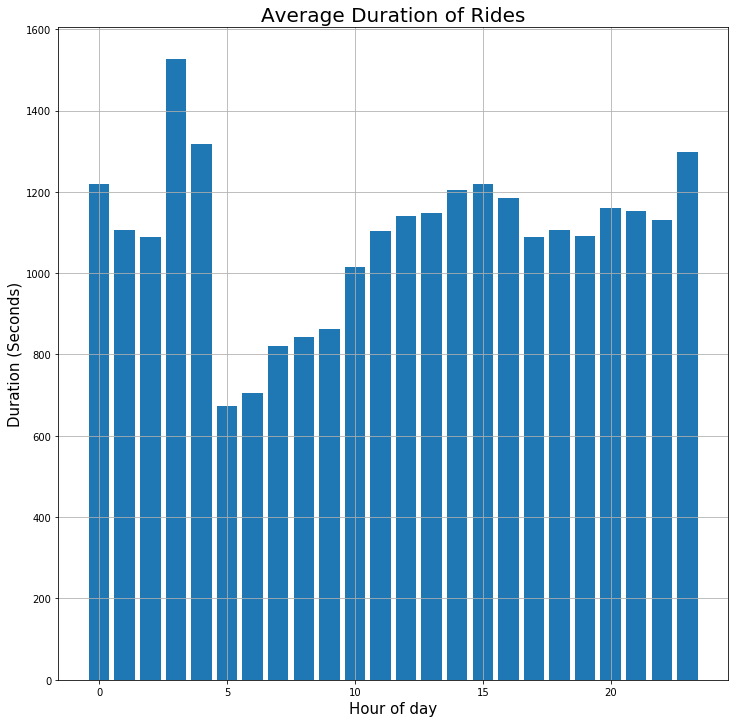

In [21]:
plt.figure(figsize=(12,12))
plt.bar(trip_dur_grouped['hour'], trip_dur_grouped['avg_duration'])
plt.title("Average Duration of Rides", fontsize=20)
plt.xlabel("Hour of day", fontsize=15)
plt.ylabel("Duration (Seconds)", fontsize=15)
plt.grid(True)

### Hour change for nighttime vs daytime for the Pearson test. Needed to be equal nightime and daytime hours...

In [23]:
# Split df into night hours and day hours

night_time_rides = cb_data_DN.loc[(cb_data_DN['hour'] < 7) | (cb_data_DN['hour'] > 18)]
day_time_rides = cb_data_DN.loc[(cb_data_DN['hour'] > 6) & (cb_data_DN['hour'] < 19)]


(1923221, 2)
   tripduration  hour
0           195     0
1           585     0
2           665     0
3           262     0
4           134     0


In [25]:
## KS Test (Full and only with 200 datapoints)
## Returned value will be KS statistic and pvalue

ks_full = scipy.stats.ks_2samp(night_time_rides.tripduration, day_time_rides.tripduration)
print(ks_full)



#Get sample of dataframes
night_sample = night_time_rides.sample(n = 200, random_state=1)
day_sample = day_time_rides.sample(n=200, random_state=1)

ks_partial = scipy.stats.ks_2samp(night_sample.tripduration, day_sample.tripduration)
print(ks_partial)

Ks_2sampResult(statistic=0.040634689346221275, pvalue=0.0)
Ks_2sampResult(statistic=0.075000000000000011, pvalue=0.61065382855701833)


## Complete Analysis for KS test (Still needs work)

Here we performed two KS tests, one with the entire dataframes and one taking only 200 datapoints from each one. Looking at the full KS test, the p-value is 0.0 which is below our significance level, meaning we can reject our null hypothesis. But the KS statistic is small and that means...

For the KS test, using a sample of each dataframe, the p-value is 0.6106. This is a two tailed p-value, so the number we are looking for is going to be half of that at *p-value = 0.3053*. Since the KS statistic is also small, this means we cannot reject the null hypothesis that trip durations are different at night time and daytime. 

By performing the analysis on the entire dataframe and then only a sample of the dataframe, we just showed that... 

### Pearson Test

In [27]:
## Pearson Test
## Returned value will be (a,b) where a is Pearson's correlation coefficient and b is the 2-tailed p value

night_sample = night_time_rides.sample(n = 2000, random_state=1)
day_sample = day_time_rides.sample(n=2000, random_state=1)

pearson_test = scipy.stats.pearsonr(night_sample.tripduration, day_sample.tripduration)
print(pearson_test)




(-0.0057391767245676762, 0.7975605826337786)


## Complete Analysis for Pearson test

From the Pearson test result above, we fail to reject the null hypothesis, as our two tailed p-value is 0.79. With a significance level set at 0.05, 0.79/2 = 0.395 is not significant. Pearson's correlation value returned also indicates that there is no correlation between the two datasets. 

### Spearman's Test

In [28]:
## Spearman's test
## Returned value will be Spearman's correlation and 2-tailed pvalue. 



spearman_test = scipy.stats.spearmanr(night_sample.tripduration, day_sample.tripduration)
print(spearman_test)

SpearmanrResult(correlation=0.0064191379042276954, pvalue=0.77419190907273205)


## Complete Analysis for Spearman Test

From the Spearman test above, we fail to reject the null hypothesis, as our two tailed p-value is 0.77 which is not significant at $ \sigma = 0.05 $. Much like the Pearson test, the correlation is nearly 0, indicating no correlation between the two datasets. 

# Start BK/Manhattan Analysis here

## Null Hypothesis



In [72]:
cb_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,195,2017-04-01 00:00:58,2017-04-01 00:04:14,217,Old Fulton St,40.702772,-73.993836,430,York St & Jay St,40.701485,-73.986569,25454,Subscriber,1966.0,1,2017-08-01 00:00:00
1,585,2017-04-01 00:01:54,2017-04-01 00:11:40,490,8 Ave & W 33 St,40.751551,-73.993934,3158,W 63 St & Broadway,40.771639,-73.982614,25930,Subscriber,1995.0,1,2017-08-01 00:00:10
2,665,2017-04-01 00:01:56,2017-04-01 00:13:01,504,1 Ave & E 16 St,40.732219,-73.981656,412,Forsyth St & Canal St,40.715816,-73.994224,27110,Subscriber,1987.0,1,2017-08-01 00:00:17
3,262,2017-04-01 00:02:24,2017-04-01 00:06:47,445,E 10 St & Avenue A,40.727408,-73.981420,411,E 6 St & Avenue D,40.722281,-73.976687,28392,Subscriber,1961.0,1,2017-08-01 00:00:27
4,134,2017-04-01 00:02:36,2017-04-01 00:04:50,3423,West Drive & Prospect Park West,40.661063,-73.979453,3300,Prospect Park West & 8 St,40.665147,-73.976376,19316,Subscriber,1967.0,2,2017-08-01 00:00:41
